```{index} single: application; cryptocurrency arbitrage
```
```{index} single: solver; cbc
```
```{index} web scraping
```
```{index} pandas dataframe
```
```{index} networkx
```
```{index} network optimization
```

# Cryptocurrency arbitrage search

Cryptocurrency exchanges are web services that enable the purchase, sale, and exchange of cryptocurrencies. These exchanges provide liquidity for owners and establish the relative value of these currencies. Joining an exchange enables a user to maintain multiple currencies in a digital wallet, buy and sell currencies, and to use cryptocurrencies for financial transactions.

In this example, we explore the efficiency of cryptocurrency exchanges by testing for arbitrage opportunities. An arbitrage exists if a customer can realize a net profit through a sequence of risk-free trades. The efficient market hypothesis assumes arbitrage opportunities are quickly identified and exploited by investors. As a result of their trading, prices reach a new equilibrium so that any arbitrage opportunities would be small and fleeting in an efficient market. The question here is whether it is possible, with real-time data and rapid execution, for a trader to profit from these fleeting arbitrage opportunities.

## Installations and Imports


### Pyomo and Solvers

First we import Pyomo and necessary solvers.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

### CCXT

In addition to Pyomo and other standard Python libraries, this notebook uses the [open-source library `ccxt`](https://github.com/ccxt/ccxt). `ccxt` supports the real-time APIs of the largest and most common exchanges on which cryptocurrencies are traded. The library can be installed with

    !pip install ccxt

Here we import all needed libraries and `ccxt`.

In [2]:
import os
import sys
from time import time
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import ccxt

### Networkx

This notebook uses the [networkx](https://networkx.org/) library to display exchange and market data. Networkx has been updated recently to version 3.0, but that update has not yet propogated through common Python distributions. If the code that follows in this notebook may generate errors on displaying networkx diagrams, it may be necessary to update the networkx library. This can be done with the following command executed in a new cell.

    !pip install networkx --upgrade

## Cryptocurrency exchanges

Cryptocurrency exchanges are digital marketplaces for buying and trading cryptocurrencies. Joining an exchange enables a member to maintain multiple currencies in a digital wallet, to buy and sell currencies, and to use cryptocurrencies for financial transactions.  Here we import the library and list current exchanges supported by `ccxt`.

In [3]:
print("Available exchanges:\n")
for i, exchange in enumerate(ccxt.exchanges):
    print(f"{i+1:3d}) {exchange.ljust(20)}", end="" if (i+1) % 4 else "\n")

Available exchanges:

  1) ace                   2) alpaca                3) ascendex              4) bequant             
  5) bigone                6) binance               7) binancecoinm          8) binanceus           
  9) binanceusdm          10) bit2c                11) bitbank              12) bitbay              
 13) bitbns               14) bitcoincom           15) bitfinex             16) bitfinex2           
 17) bitflyer             18) bitforex             19) bitget               20) bithumb             
 21) bitmart              22) bitmex               23) bitopro              24) bitpanda            
 25) bitrue               26) bitso                27) bitstamp             28) bitstamp1           
 29) bittrex              30) bitvavo              31) bkex                 32) bl3p                
 33) blockchaincom        34) btcalpha             35) btcbox               36) btcex               
 37) btcmarkets           38) btctradeua           39) btcturk       

## Representing an exchange as a directed graph

First, we need some terminology. Trading between two specific currencies is called a market, with each exchange hosting multiple markets. `ccxt` labels each market with a symbol common across exchanges. The market symbol is an upper-case string with abbreviations for a pair of traded currencies separated by a slash ($/$). The first abbreviation is the base currency, the second is the quote currency. Prices for the base currency are denominated in units of the quote currency. As an example, $ETH/BTC$ refers to a market for the base currency Ethereum (ETH) quoted in units of the Bitcoin (BTC). The same market symbol can refer to an offer to sell the base currency (a 'bid') or to an offer to sell the base currency (an 'ask'). For example, $x$ ETH/BTC means you can buy $x$ units of BTC with one unit of ETH.

An exchange can be represented by a directed graph constructed from the market symbols available on that exchange. There, currencies correspond to nodes on the directed graph. Market symbols correspond to edges in the directed graph, with the source indicating the quote currency and the destination indicating the base currency. The following code develops such a sample graph.

Number of nodes =  15
Number of edges =  60


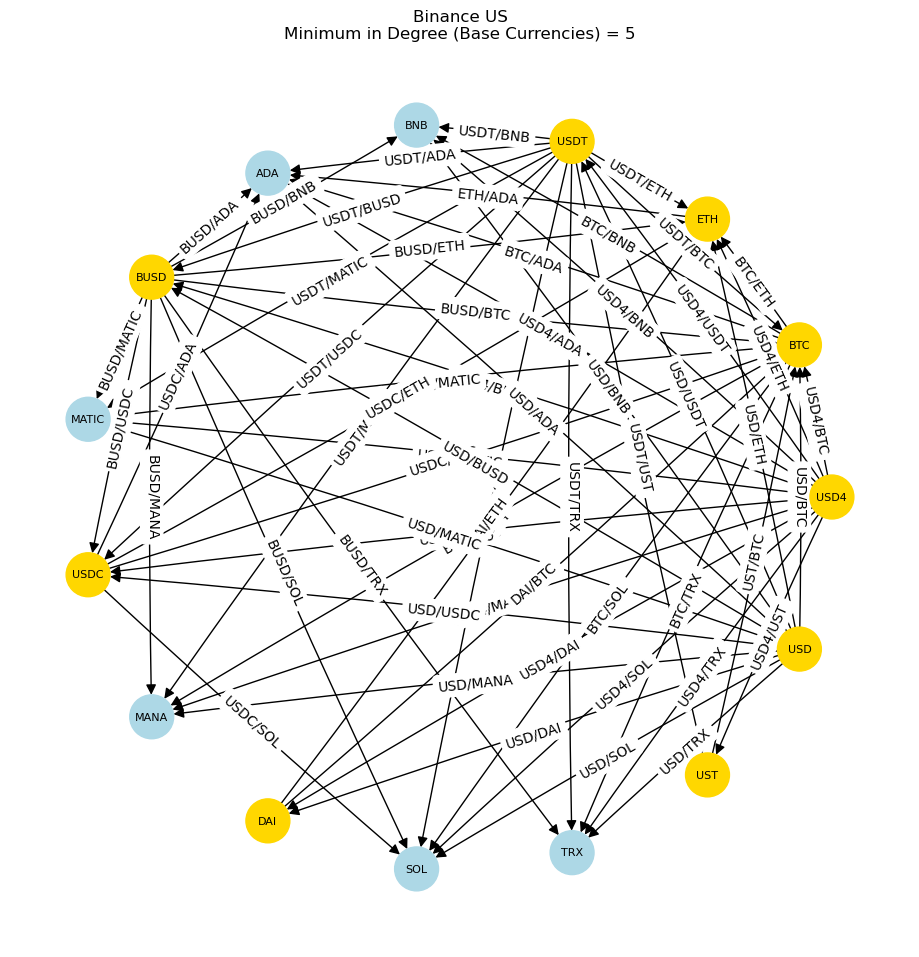

In [4]:
# global variables used in subsequent cells

# create an exchange object
exchange = ccxt.binanceus()

def get_dg(exchange, minimum_in_degree=1):
    """
    Return a directed graph constructed from the market symbols on a specified exchange.
    """
    markets = exchange.load_markets()
    symbols = markets.keys()

    # create an edge for all market symbols
    dg = nx.DiGraph()
    for base, quote in [symbol.split("/") for symbol in symbols]:
        dg.add_edge(quote, base, color="k", width=1)
    
    # remove base currencies with in_degree less than minimum_in_degree
    remove_nodes = [node for node in dg.nodes if dg.out_degree(node) == 0 and dg.in_degree(node) < minimum_in_degree]
    dg.remove_nodes_from(remove_nodes)
    
    # color quote currencies in gold
    for node in dg.nodes():
        dg.nodes[node]["color"] = "gold" if dg.out_degree(node) > 0 else "lightblue"

    return dg

def draw_dg(dg, rad=0.0):
    """
    Draw directed graph of markets symbols.
    """
    n_nodes = len(dg.nodes)
    size = int(2.5 * np.sqrt(n_nodes))
    fig = plt.figure(figsize=(size, size))
    pos = nx.circular_layout(dg)
    nx.draw(
        dg, 
        pos,
        with_labels=True,
        node_color=[dg.nodes[node]["color"] for node in dg.nodes()],
        edge_color=[dg.edges[u, v]["color"] for u, v in dg.edges],
        width=[dg.edges[u, v]["width"] for u, v in dg.edges],
        node_size=1000,
        font_size=8,
        arrowsize=15,
        connectionstyle=f"arc3, rad={rad}",
    )
    nx.draw_networkx_edge_labels(dg, pos, edge_labels={(src, dst): f"{src}/{dst}" for src, dst in dg.edges()})

    return plt.gca()

minimum_in_degree = 5
dg = get_dg(exchange, minimum_in_degree)
ax = draw_dg(dg, 0.01)
ax.set_title(exchange.name + "\n" + f"Minimum in Degree (Base Currencies) = {minimum_in_degree}")

print(f"Number of nodes = {len(dg.nodes()):3d}")
print(f"Number of edges = {len(dg.edges()):3d}")

## Exchange order book

The order book for a currency exchange is the real-time inventory of trading orders. 

A **bid** is an offer to buy up to a specified amount of the base currency at the price not exceeding the 'bid price' in the quote currency.  An **ask** is an offer to sell up to a specified amount of the base currency at a price no less than a value specified given in the quote currency. 

The exchange attempts to match the bid to ask order at a price less than or equal to the bid price. If a transaction occurs, the  buyer will receive an amount of base currency less than or equal to the bid volume and the ask volume, at a price less than or equal to the bid price and no less than the specified value.

The order book for currency exchange is the real-time inventory of orders. The exchange order book maintains a list of all active orders for symbols traded on the exchange. Incoming bids above the lowest ask or incoming asks below the highest bid will be immediately matched and transactions executed following the rules of the exchange.

The following cell reads and displays a previously saved order book.  Cells at the end of this notebook demonstrate how to retrieve an order book from an exchange and save it as a Pandas DataFrame.

In [5]:
import glob

# find all previously saved order books
fnames = sorted(glob.glob(f"*orderbook*".replace(" ","_")))
fname = fnames[-1]

# read the oldest
print(f"\nReading: {fname}\n")
order_book = pd.read_csv(fname, index_col=0)
display(order_book)


Reading: Binance_US_orderbook_saved.csv



,symbol,timestamp,base,quote,bid_price,bid_volume,ask_price,ask_volume
0,ETH/BTC,2023-03-02 15:36:06.529,ETH,BTC,0.069735,0.012000,0.069759,0.050000
1,BNB/BTC,2023-03-02 15:36:06.583,BNB,BTC,0.012743,0.050000,0.012755,3.000000
2,ADA/BTC,2023-03-02 15:36:06.637,ADA,BTC,0.000015,2.000000,0.000015,2168.000000
3,SOL/BTC,2023-03-02 15:36:06.690,SOL,BTC,0.000935,1.420000,0.000936,15.120000
4,MATIC/BTC,2023-03-02 15:36:06.750,MATIC,BTC,0.000052,26.200000,0.000052,150.200000
5,MANA/BTC,2023-03-02 15:36:06.848,MANA,BTC,0.000027,831.000000,0.000027,1409.000000
6,TRX/BTC,2023-03-02 15:36:06.905,TRX,BTC,0.000003,4.000000,0.000003,25352.000000
7,ADA/ETH,2023-03-02 15:36:06.960,ADA,ETH,0.000214,994.900000,0.000214,891.600000
8,BTC/USDT,2023-03-02 15:36:07.012,BTC,USDT,23373.920000,0.118619,23376.000000,0.045275
9,ETH/USDT,2023-03-02 15:36:07.065,ETH,USDT,1630.200000,0.950000,1630.770000,0.500000


## Modelling the arbitrage search problem as a graph

Our goal will be to find arbitrage opportunities, i.e., the possibility to start from a given currency and, through a sequence of executed trades, arrive back at the same currency with a higher balance than at the beginning. We will model this problem as a network one.

A bid appearing in the order book for market symbol $b/q$ is an order from a prospective counter party to purchase an amount of the base currency $b$ at a bid price given in a quote currency $q$. For a currency trader, a bid in the order book is an opportunity to convert the base currency $b$ into the quote currency $q$.

The order book can be represented as a directed graph where nodes correspond to individual currencies. A directed edge $b\rightarrow q$ from node $b$ to node $q$ describes an opportunity for us to convert currency $b$ into units of currency $q$. Let $V_b$ and $V_q$ denote the amounts of each currency held by us, and let $x_{b\rightarrow q}$ denote the amount of currency $b$ exchanged for currency $j$. Following the transaction $x_{b\rightarrow q}$ we have the following changes to the currency holdings
$$
\begin{align*}
    \Delta V_b & = - x_{b\rightarrow q} \\
    \Delta V_q & = a_{b\rightarrow q} x_{b\rightarrow q},
\end{align*}
$$
where $a_{b\rightarrow q}$ is a *conversion coefficient* equal to the price of $b$ expressed in terms of currency $q$. The capacity $c_{b\rightarrow q}$ of an trading along edge $b\rightarrow q$ is specified by a relationship

$$
    x_{b\rightarrow q} \leq c_{b\rightarrow q}.
$$

Because the arcs in our graph correspond to two types of orders - bid and ask - we need to build a consistent way of expressing them in our  $a_{b\rightarrow q}$, $c_{b\rightarrow q}$ notation. So now, imagine that we are the party that accepts the buy and ask bids existing in the graph.

For bid orders, we have a chance to convert the base currency $b$ into the quote currency $q$, for which we will use the following notation:

$$
\begin{align*}
a_{b\rightarrow q} & = \text{bid price} \\
c_{b\rightarrow q} & = \text{bid volume}
\end{align*}
$$

An ask order for symbol $b/q$ is an order to sell the base currency at price not less than the 'ask' price given in terms of the quote currency. The ask volume is the amount of base currency to be sold. For us, a sell order is an opportunity to convert the quoted currency into the base currency such that

$$
\begin{align*}
a_{q\rightarrow b} & = \frac{1}{\text{ask price}} \\
c_{q\rightarrow b} & = \text{ask volume} \times \text{ask volume}
\end{align*}
$$

The following cell creates a directed graph using data from an exchange order book. To distinguish between different order types, we will highlight the big orders with green color, and ask orders with red color.

In [6]:
def order_book_to_dg(order_book):
    """
    Convert an order book dataframe into a directed graph using the NetworkX library.

    Parameters:
    -----------
    order_book : pandas.DataFrame
        A dataframe containing the order book information.

    Returns:
    --------
    dg_order_book : networkx.DiGraph
        A directed graph representing the order book.
    """
    
    # create a dictionary of edges index by (src, dst)
    dg_order_book = nx.DiGraph()
    
    # loop over each order in the order book dataframe
    for order in order_book.index:
        # if the order is a 'bid', i.e., an order to purchase the base currency
        if not np.isnan(order_book.at[order, "bid_volume"]):
            src = order_book.at[order, "base"]
            dst = order_book.at[order, "quote"]
            # add an edge to the graph with the relevant attributes
            dg_order_book.add_edge(src, dst,
                kind = "bid",
                a = order_book.at[order, "bid_price"],
                capacity = order_book.at[order, "bid_volume"],
                weight = - np.log(order_book.at[order, "bid_price"]),
                color = "g",
                width = 0.5,
            )

        # if the order is an 'ask', i.e., an order to sell the base currency
        if not np.isnan(order_book.at[order, "ask_volume"]):
            src = order_book.at[order, "quote"]
            dst = order_book.at[order, "base"]
            # add an edge to the graph with the relevant attributes
            dg_order_book.add_edge(src, dst,
                kind = "ask",
                a = 1.0 / order_book.at[order, "ask_price"],
                capacity = order_book.at[order, "ask_volume"] * order_book.at[order, "ask_price"],
                weight = - np.log(1.0 / order_book.at[order, "ask_price"]),
                color = "r",
                width = 0.5,
            )

    # loop over each node in the graph and set the color attribute to "lightblue"
    for node in dg_order_book.nodes():
        dg_order_book.nodes[node]["color"] = "lightblue"

    return dg_order_book

dg_order_book = order_book_to_dg(order_book)

First, we simply print the content of the order book as a list of arcs.

In [7]:
# display contents of the directed graph
print(f"src   --> dst    kind            a                c")
print(f"------------------------------------------------------")
for src, dst in dg_order_book.edges():
    print(f"{src:5s} --> {dst:5s}   {dg_order_book.edges[(src, dst)]['kind']}" +
          f"{dg_order_book.edges[(src, dst)]['a']: 16f} {dg_order_book.edges[(src, dst)]['capacity']: 16f}    ")

src   --> dst    kind            a                c
------------------------------------------------------
ETH   --> BTC     bid        0.069735         0.012000    
ETH   --> ADA     ask     4668.534080         0.190981    
ETH   --> USDT    bid     1630.200000         0.950000    
ETH   --> BUSD    bid     1630.210000         0.510000    
ETH   --> USDC    bid     1630.160000         0.100000    
ETH   --> DAI     bid     1629.890000         0.497400    
ETH   --> USD     bid     1630.490000         2.564550    
BTC   --> ETH     ask       14.335068         0.003488    
BTC   --> BNB     ask       78.403701         0.038263    
BTC   --> ADA     ask    66844.919786         0.032433    
BTC   --> SOL     ask     1068.261938         0.014154    
BTC   --> MATIC   ask    19391.118868         0.007746    
BTC   --> MANA    ask    36968.576710         0.038113    
BTC   --> TRX     ask   335570.469799         0.075549    
BTC   --> USDT    bid    23373.920000         0.118619    
BTC   --

Next, we draw the graph itself.

<Axes: >

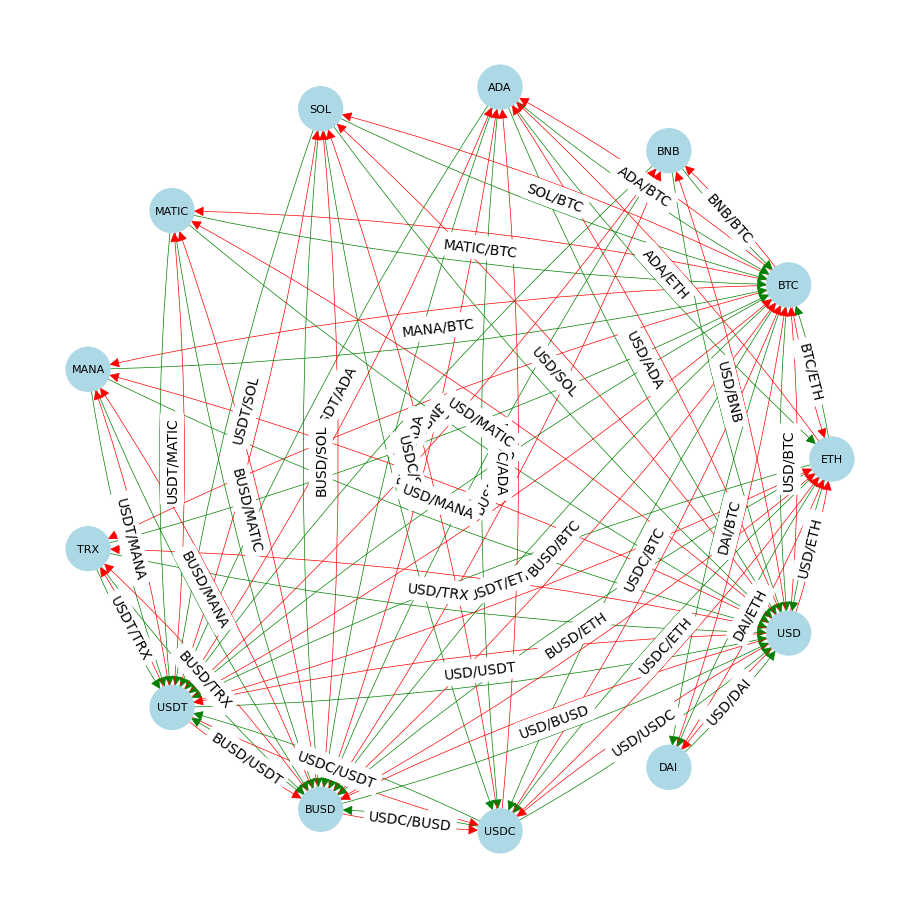

In [8]:
draw_dg(dg_order_book, 0.05)

## Trading and Arbitrage

With the unified treatment of the bid and ask orders, we are ready to pose the mathematical problem of finding an arbitrage opportunity. An arbitrage exists if it is possible to find a closed path and a sequence of transactions in the directed graph that results in a net increase in currency holdings. Given a path

\begin{align*}
    i_0 \rightarrow i_1 \rightarrow i_2 \rightarrow \cdots \rightarrow i_{n-1} \rightarrow i_n
\end{align*}

the path is closed if $i_n = i_0$. The path has finite capacity if each edge in the path has a non-zero capacity. For a sufficiently small holding $w_{i_0}$ of currency $i_0$ (because of the capacity constraints), a closed path with $i_0 = i_n$ represents an arbitrage opportunity if 

\begin{equation} 
    \prod_{k=0}^{n-1} a_{i_k\rightarrow i_{k+1}} > 1.
\end{equation}

If all we care about is simply finding an arbitrage cycle, regardless of the volume traded, we can use one of the many shortest path algorithms from the `networkx` library. To convert the problem of finding a path meeting  the above condition into a sum-of-terms to be minimized, we can take the negative logarithm of both sides to obtain the condition:

\begin{align*}
    -\log(\prod_{k=0}^{n-1} a_{i_k\rightarrow i_{k+1}}) = - \sum\limits_{k = 0}^{n-1} \log (a_{i_k\rightarrow i_{k+1}}) < 0,
\end{align*}

In other words, if we assign the negative logarithm as the weight of arcs in a graph, then our problem just became translated into the problem of searching for a cycle with a total sum of weights along it to be negative.

## Find order books that demonstrate arbitrage opportunities

A simple cycle is a closed path where no node appears twice. Simple cycles are distinct if they are not cyclic permutations (essentially, rewriting the same path but with a different start=end point) of each other. One could check for arbitrage opportunities by checking if there are any negative simple cycles in the graph.

However, looking for a negative-weight cycle through searching for an arbitrage opportunity can be a daunting task - a brute force search over all simple cycles has complexity $(n + e)(c + 1)$ which is impractical for larger scale applications. A more efficient search based on the Bellman-Ford algorithm is embedded in the NetworkX function [`negative_edge_cycle`](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.negative_edge_cycle.html) that returns a logical True if a negative cycle exists in a directed graph. 

In [9]:
dg_order_book = order_book_to_dg(order_book)
nx.negative_edge_cycle(dg_order_book, weight="weight", heuristic=True)

True

The function `negative_edge_cycle` s fast, but it only indicates if there is a negative cycle or not, and we don't even know what kind of a cycle is it so it would be hard to use that information to perform an arbitrage.

Luckily, the `networkx` library includes the function [`find_negative_cycle` that locates a single negative edge cycle](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.find_negative_cycle.html) if one exists. We can use this to demonstrate the existence of an arbitrage opportunity, and to highlight that opportunity on the directed graph of all possible trades. The following cell reports the cycle found and the trading return measured in basis points (1 bp = 0.01%), and marks it with thicker arcs i the graph.

Trading cycle: ['USDC', 'USDT', 'BUSD']
5.002 basis points


Text(0.5, 1.0, 'Candidate Trading Cycle 5.002 basis points return')

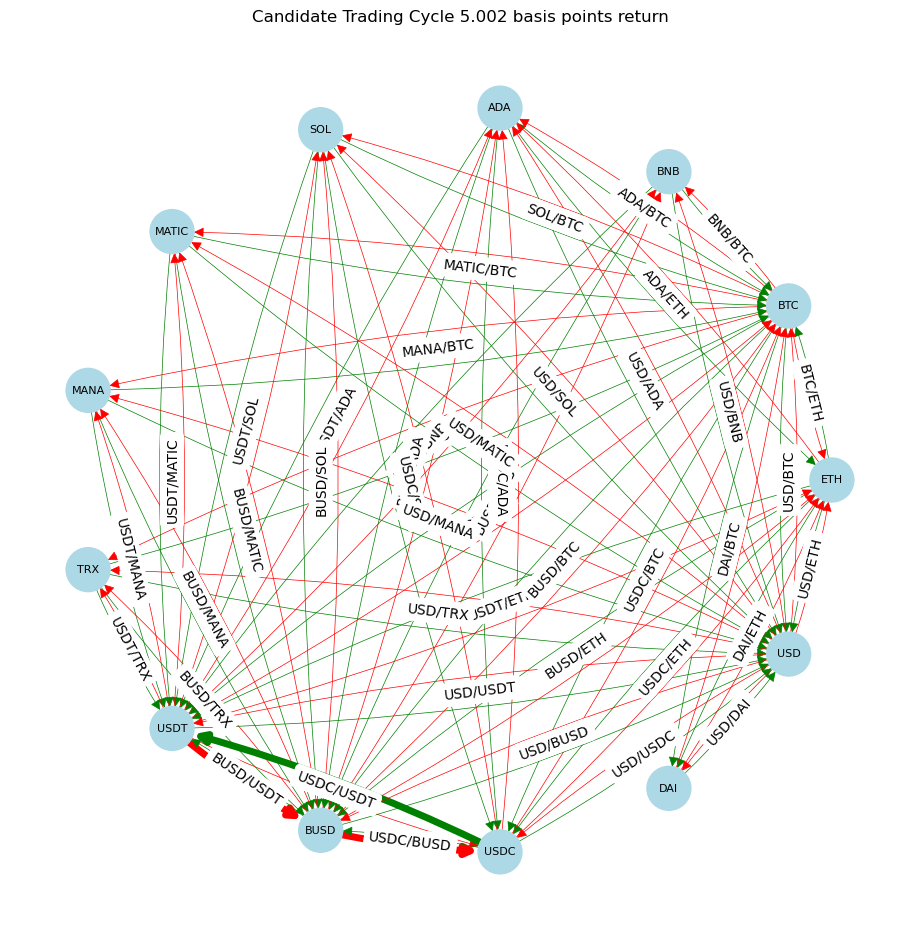

In [10]:
# compute the sum of weights given a list of nodes
def sum_weights(cycle):
    return sum([dg_order_book.edges[edge]["weight"] for edge in zip(cycle, cycle[1:] + cycle[:1])])

dg_order_book = order_book_to_dg(order_book)
arb = nx.find_negative_cycle(dg_order_book, weight="weight", source="USD")[:-1]
print(f"Trading cycle: {arb}")
bp = 10000 * (np.exp(-sum_weights(arb)) - 1)
print(f"{bp:0.3f} basis points")
    
for src, dst in zip(arb, arb[1:] + arb[:1]):
    dg_order_book[src][dst]["width"] = 5
    
ax = draw_dg(dg_order_book, 0.05)
ax.set_title(f"Candidate Trading Cycle {bp:0.3f} basis points return")

Note this may or may not the trading cycle with maximum return. There may be other cycles with higher or lower returns, and that allow higher or lower trading volumes.

## Brute force search arbitrage with simple cycles

Not all arbitrage cycles are the same - some yield a higher relative return (per dollar invested) than the others, and some yield a higher absolute return (maximum amount of money to be made risk-free) than others. This is because the amount of money that flows throught a negative cycle is upper bounded by the size of the smallest order in that cycle. Thus, if one is looking for the best possible arbitrage sequence of trades, finding just 'a cycle' might not be enough.

A crude way to search for a good arbitrage opportunity would be to enumerate all possible simple cycles in a graph and pick the one that's best according to whatever criterion we pick. A brute force search over for all simple cycles has order $(N_{nodes} + N_{edges})(N_{cycles} + 1)$ complexity, which is prohibitive for large order books. Nevertheless, we explore this option here to better understand the problem of finding and valuing arbitrage opportunities.

In the following cell, we compute the loss function for all simple cycles that can be constructed within a directed graph using the function [`simple_cycles`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html) from the `networkx` library to construct a dictionary of all distinct simple cycles in the order book. Each cycle is represented by an ordered list of nodes. For each cycle, the financial return is computed, and a histogram is constructed to show the distribution of potential returns. Several paths with the highest return are then overlaid on the graph of the order book.

Again, note that no account is taken of the trading capacity available on each path.

There are 203147 distinct simple cycles in the order book.
   974 of the cycles have positive return.


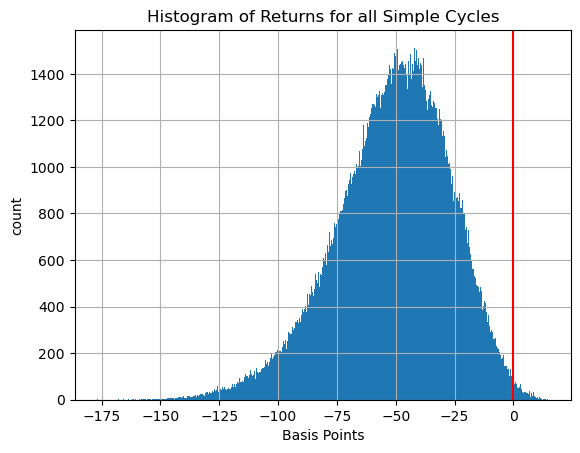

In [11]:
# This cell iterates over all simple cycles in a directed graph. This
# can a long time for a large, well connected graph. 

# convert order book to a directed graph
dg_order_book = order_book_to_dg(order_book)

# compute the sum of weights given a list of nodes
def sum_weights(cycle):
    return sum([dg_order_book.edges[edge]["weight"] for edge in zip(cycle, cycle[1:] + cycle[:1])])

# create a dictionary of all simple cycles and sum of weights
cycles = {tuple(cycle): 10000 * (np.exp(-sum_weights(cycle)) - 1) for cycle in nx.simple_cycles(dg_order_book)}

print(f"There are {len(cycles)} distinct simple cycles in the order book.")
print(f"   {len([cycle for cycle in cycles if cycles[cycle] > 0])} of the cycles have positive return.")

# create histogram
plt.hist(cycles.values(), bins=int(np.sqrt(len(cycles))))
ax = plt.gca()
ax.set_ylabel("count")
ax.set_xlabel("Basis Points")
ax.set_title("Histogram of Returns for all Simple Cycles")
ax.grid(True)
ax.axvline(0, color='r')

Next, we sort out the negative cycles from this list and present them along with their basis-points (1% is 100 basis points) return.

In [17]:
arbitrage = [cycle for cycle in sorted(cycles, key=cycles.get, reverse=True) if cycles[cycle] > 0]

n_cycles_to_list = 5

print(f"Top {n_cycles_to_list}\n")
print(f"Basis Points             Arbitrage Cycle")
for cycle in arbitrage[0: min(n_cycles_to_list, len(arbitrage))]:
    t = list(cycle)
    t.append(cycle[0])
    print(f"{cycles[cycle]:6.3f}         {len(t)} trades: {' -> '.join(t)}")

Top 5

Basis Points             Arbitrage Cycle
14.774         8 trades: USDC -> USDT -> ADA -> BTC -> ETH -> USD -> BUSD -> USDC
14.747         8 trades: TRX -> BTC -> ETH -> USD -> BUSD -> USDC -> USDT -> TRX
14.699         7 trades: USDC -> USDT -> ADA -> BTC -> USD -> BUSD -> USDC
14.673         7 trades: TRX -> BTC -> USD -> BUSD -> USDC -> USDT -> TRX
13.772         7 trades: USDC -> USDT -> ADA -> BTC -> ETH -> USD -> USDC


In the end, we draw an example arbitrage cycle on our graph to illustrate the route that the money must travel.

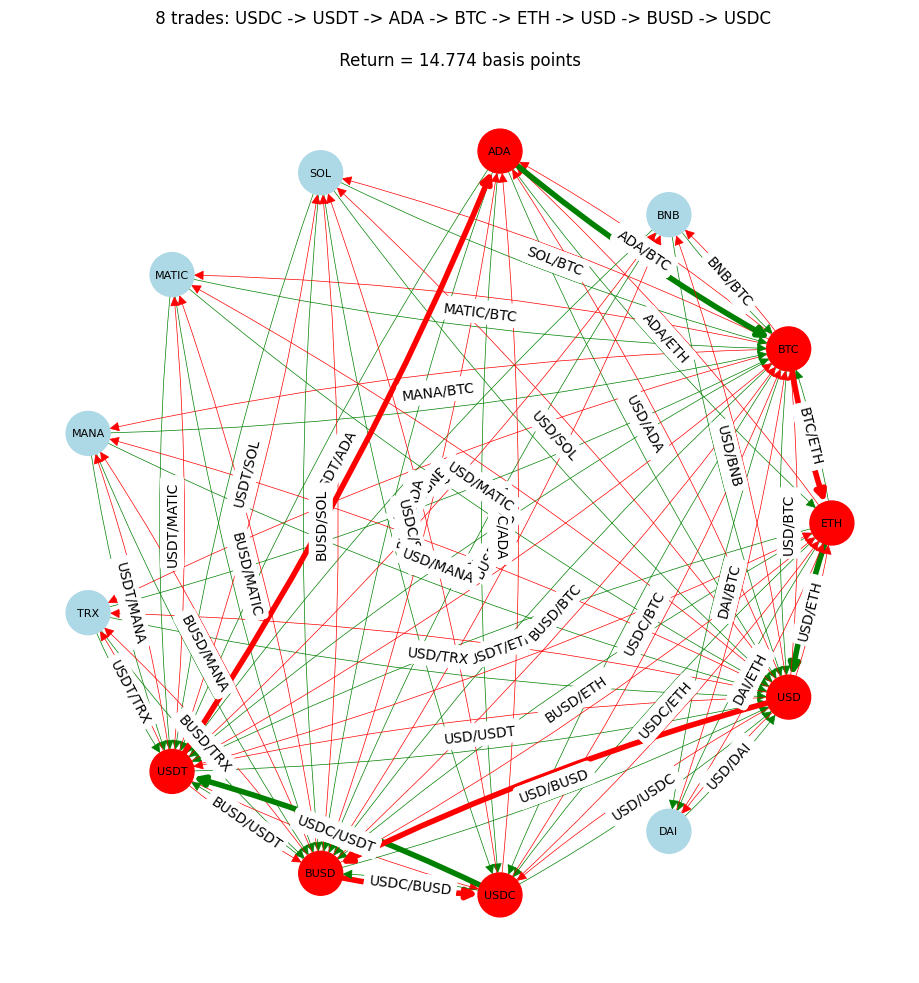

In [18]:
n_cycles_to_show = 1

for cycle in arbitrage[0: min(n_cycles_to_show, len(arbitrage))]:

    # get fresh graph to color nodes
    dg_order_book = order_book_to_dg(order_book)
    
    # color nodes red
    for node in cycle:
        dg_order_book.nodes[node]['color'] = 'red'
    
    # makes lines wide
    for edge in zip(cycle, cycle[1:] + cycle[:1]):
        dg_order_book.edges[edge]['width'] = 4
        
    ax = draw_dg(dg_order_book, rad=0.05)

    t = list(cycle)
    t.append(cycle[0])
    ax.set_title(f" {len(t)} trades: {' -> '.join(t)}\n\n Return = {cycles[cycle]:6.3f} basis points ")

## Pyomo Model for Arbitrage with Capacity Constraints

The preceding analysis shows that depending on generic network algorithms to find arbitrage in an exchange order book has some practical limitations:

* Since there can be multiple negative cycles, there may be more than one opportunity for arbitrage. Which opportunity offers the greatest potential for profit?
* Shortest path algorithms do not account for capacity constraints. The network algorithms are restricted to investments small enough to satisfy all capacity constraints on every edge.

Instead, we can formulate the problem of searching for a maximum-gain arbitrage via linear programming. We assume we are given a directed graph where each edge $i\rightarrow j$ is labeled with a 'multiplier' $a_{i\rightarrow j}$ indicating how many units of currency $j$ will be received for one unit of currency $i$, and a 'capacity' $c_{i\rightarrow j}$ indicating how many units of currency $i$ can be converted to currency $j$.

We will break the trading process down into steps indexed by $t = 1, 2, \ldots, T$, where currencies are exchanged between two adjacent nodes within a single step. We shall denote by $x_{i\rightarrow j}(t)$ the currency amount traded from node $i$ to $j$ in step $t$. In this way, we start with the amount $w_{USD}(0)$ at time $0$ and aim to maximize the amount $w_{USD}(T)$ at time $T$. Denote by $O_j$ the set of nodes to which outgoing arcs from $j$ lead, and by $I_j$ the set of nodes from which incoming arcs lead.

A single transaction converts $x_{i\rightarrow j}(t)$ units of currency $i$ to currency $j$. Following the all transactions at event $t$, the trader will hold $v_j(t)$ units of currency $j$ where

$$v_{j}(t) = v_{j}(t-1) + \sum_{i\in I_j} a_{i\rightarrow j}x_{i\rightarrow j}(t) - \sum_{k\in O_j} x_{j\rightarrow k}(t)$$

For every edge $i\rightarrow j$, the sum of all transactions must satisfy

$$\sum_{t=1}^T x_{j\rightarrow k}(t) \leq c_{j\rightarrow k}$$

The objective of the optimization model is to find a sequence of currency transactions the increase holdings of a reference currency. The solution is constrained by assuming the trader cannot short sell any currency. The resulting model is

$$
\begin{align*}
\max \quad & v_{USD}(T) \\
\\
\text{s.t.} \quad & v_{USD}(0) = v_0 \\ 
\\
& v_{j}(t) = v_{j}(t-1) + \sum_{i\in I_j} a_{i\rightarrow j}x_{i\rightarrow j}(t) - \sum_{k\in O_k} x_{j\rightarrow k}(t) & \forall j\in NODES, t=1, 2, \ldots, T \\
& v_j(t-1) \geq \sum_{k\in O_j} x_{j\rightarrow k}(t) & \forall j\in NODES, t = 1, 2, \ldots, T  \\
& \sum_{t=1}^T x_{j\rightarrow k}(t) \leq c_{j\rightarrow k} & \forall (j, k) \in EDGES,  t = 1, 2, \ldots, T \\
& v_{j}(t), x_{i\rightarrow j}(t) \geq 0,  \label{ch4eq:problem.con5} && \forall t
\end{align*}
$$

where the subsequent constraints are the:
* initial amount condition,
* balance equations linking the state of the given node in the previous and subsequent time periods,
* constraint that we cannot trade at time step $t$ more of a given currency that we had in this currency from time step $t - 1$. This constraint 'enforces' the time order of trades, i.e., we cannot trade in time period $t$ units which have been received in the same time period.
* the capacity constraints related to the maximum allowed trade volumes,
* non-negativity constraints.

The following Python code illustrates this formulation.

In [19]:
import pyomo.environ as pyo

def crypto_model(dg_order_book, T = 10, v0 = 100.0):

    m = pyo.ConcreteModel(f"{exchange} arbitrage")

    # length of the trading chain
    m.T0 = pyo.RangeSet(0, T)
    m.T1 = pyo.RangeSet(1, T)

    # currency nodes and trading edges
    m.NODES = pyo.Set(initialize=list(dg_order_book.nodes))
    m.EDGES = pyo.Set(initialize=list(dg_order_book.edges))

    # currency on hand at each node
    m.v = pyo.Var(m.NODES, m.T0, domain=pyo.NonNegativeReals)

    # amount traded on each edge at each trade
    m.x = pyo.Var(m.EDGES, m.T1, domain=pyo.NonNegativeReals)

    # total amount traded on each edge over all trades
    m.z = pyo.Var(m.EDGES, domain=pyo.NonNegativeReals)

    # "multiplier" on each trading edge
    @m.Param(m.EDGES)
    def a(m, src, dst):
        return dg_order_book.edges[(src, dst)]["a"]

    @m.Param(m.EDGES)
    def c(m, src, dst):
        return dg_order_book.edges[(src, dst)]["capacity"]

    @m.Objective(sense=pyo.maximize)
    def wealth(m):
        return m.v["USD", T]

    @m.Constraint(m.EDGES)
    def total_traded(m, src, dst):
        return m.z[src, dst] == sum([m.x[src, dst, t] for t in m.T1])

    @m.Constraint(m.EDGES)
    def edge_capacity(m, src, dst):
        return m.z[src, dst] <= m.c[src, dst]

    # initial assignment of 100 units on a selected currency
    @m.Constraint(m.NODES)
    def initial(m, node):
        if node == "USD":
            return m.v[node, 0] == v0
        return m.v[node, 0] == 0.0

    @m.Constraint(m.NODES, m.T1)
    def no_shorting(m, node, t):
        out_nodes = [dst for src, dst in m.EDGES if src == node]
        return m.v[node, t - 1] >= sum(m.x[node, dst, t] for dst in out_nodes)

    @m.Constraint(m.NODES, m.T1)
    def balances(m, node, t):
        in_nodes = [src for src, dst in m.EDGES if dst == node]
        out_nodes = [dst for src, dst in m.EDGES if src == node]
        return m.v[node, t] == m.v[node, t - 1] + sum(m.a[src, node] * m.x[src, node, t] for src in in_nodes) - sum(m.x[node, dst, t] for dst in out_nodes) 

    solver = pyo.SolverFactory("cbc")
    solver.solve(m)
    
    return m

Using this function, we are able to compute the optimal (absolute) return from an order book while respecting the order capacities and optimally using all the arbitrage opportunities inside it.

In [20]:
dg_order_book = order_book_to_dg(order_book)

v0 = 10000.0
T = 8
m = crypto_model(dg_order_book, T=T, v0=v0)
vT = m.wealth()

print(f"Starting wealth = {v0:0.2f} USD")
print(f"Weath after {T:2d} transactions = {vT:0.2f} USD")
print(f"Return = {10000 * (vT - v0)/v0:0.3f} basis points")
print()

Starting wealth = 10000.00 USD
Weath after  8 transactions = 10009.01 USD
Return = 9.007 basis points



To track the evolution of the trades throughout time, the script in the following cell illustrates, for each currency (rows) the amount of money held in that currency at each of the time steps $t = 0, \dots, 8$. It is visible from this scheme that the sequence of trades is not a simple cycle, but rather a more sophisticated sequence of trades which we would not have discovered with simple-cycle exploration alone, especially not when considering also the arc capacities.

In [22]:
for node in m.NODES:
    print(f"{node:5s}", end="")
    for t in m.T0:
        print(f" {m.v[node, t]():11.5f}", end="")
    print()

ETH       0.00000     0.00000     0.00000     0.00000    -0.00000     0.00000     0.00000     0.00000     0.00000
BTC       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00004     0.00000
BNB       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
ADA       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     2.00000     0.00000     0.00000
SOL       0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
MATIC     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
MANA      0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000     0.00000
TRX       0.00000     0.00000     0.00000    -0.00000     0.00000    -0.00000     4.00000     0.00000     0.00000
USDT      0.00000  9998.02600     0.97433    -0.00000 10003.02700     0.97482     0.0000

To be even more specific, the following cell lists the sequence of transcations executed.

In [23]:
print("\nTransaction Events")
for t in m.T1:
    print(f"t = {t}")
    for src, dst in m.EDGES:
        if m.x[src, dst, t]() > 1e-6:
            print(f" {src:8s} -> {dst:8s}: {m.x[src, dst, t]():14.6f} {m.a[src, dst] * m.x[src, dst, t]():14.6f}")
    print()


Transaction Events
t = 1
 USD      -> USDT    :    9999.025800    9998.025997
 USD      -> USDC    :       0.974235       0.974235

t = 2
 USDT     -> BUSD    :    9998.026000   10002.026811
 USDC     -> USDT    :       0.974235       0.974333

t = 3
 USDT     -> BUSD    :       0.974333       0.974723
 BUSD     -> USDC    :   10002.027000   10002.027000

t = 4
 BUSD     -> USDC    :       0.974723       0.974723
 USDC     -> USDT    :   10002.027000   10003.027203

t = 5
 USDT     -> BUSD    :   10003.027000   10007.029812
 USDC     -> USDT    :       0.974723       0.974820

t = 6
 USDT     -> ADA     :       0.697500       2.000000
 USDT     -> TRX     :       0.277320       4.000000
 BUSD     -> USDC    :   10007.030000   10007.030000

t = 7
 ADA      -> BTC     :       2.000000       0.000030
 TRX      -> BTC     :       4.000000       0.000012
 USDC     -> USDT    :   10007.030000   10008.030703

t = 8
 BTC      -> USD     :       0.000042       0.976057
 USDT     -> USD     :  

We next illustrate the arbitrage strategy in the graph by marking all the correspondings arcs thicker.

<Axes: >

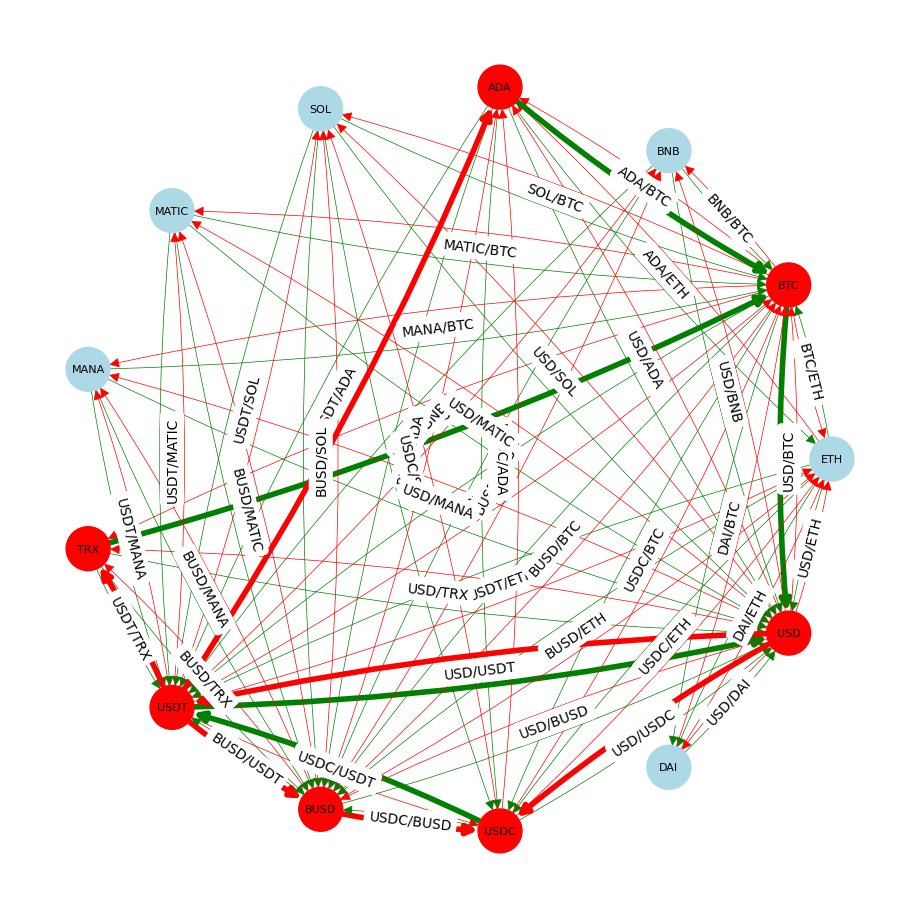

In [40]:
# add comment in the text to remind the reader about bids and asks
# for each currency we took only one ask and one bid, this is why we are unique between each pair of nodes

# report what orders to issue
for src, dst in m.EDGES:
    if m.z[src, dst]() > 0.0000002: 
        dg_order_book.nodes[src]["color"] = "red"
        dg_order_book.nodes[dst]["color"] = "red"
        dg_order_book[src][dst]["width"] = 4
                
draw_dg(dg_order_book, 0.05)

If we want to be even more precise about the execution of the trading strategy, we can formulate a printout of the list of orders that we, as the counterparty to the orders stated in the order book, should issue for our strategy to take place.

In [30]:
# report what orders to issue
print("Trading Summary for the Order Book")
print(f"  Order Book   Type    Capacity         Traded")
for src, dst in m.EDGES:
    if m.z[src, dst]() > 0.0000002:
        kind = dg_order_book.edges[(src,dst)]['kind']
        s = f"{src:>5s} -> {dst:<5s} {kind} {m.c[src, dst]:12.5f} {m.z[src, dst]():14.5f}"
        s += "  >>>  "
        if kind == "ask":
            base = dst
            quote = src
            symbol = base + "/" + quote
            price = 1.0 / dg_order_book.edges[(src, dst)]["a"]
            volume = m.z[src, dst]() / price
            s += f"sell {volume:15.6f} {symbol:11s} at {price:12.6f}"
            
        if kind == "bid":
            base = src
            quote = dst
            symbol = base + "/" + quote
            price = dg_order_book.edges[(src, dst)]["a"]
            volume = m.z[src,dst]() 
            s += f"buy {volume:16.6f} {symbol:11s} at {price:12.6f}"  
        print(s)
            

Trading Summary for the Order Book
  Order Book   Type    Capacity         Traded
  BTC -> USD   bid      0.00746        0.00004  >>>  buy         0.000042 BTC/USD     at 23373.010000
  ADA -> BTC   bid      2.00000        2.00000  >>>  buy         2.000000 ADA/BTC     at     0.000015
  TRX -> BTC   bid      4.00000        4.00000  >>>  buy         4.000000 TRX/BTC     at     0.000003
 USDT -> ADA   ask    178.28100        0.69750  >>>  sell        2.000000 ADA/USDT    at     0.348750
 USDT -> BUSD  ask 317048.85971    20002.02700  >>>  sell    20010.031012 BUSD/USDT   at     0.999600
 USDT -> TRX   ask    750.05354        0.27732  >>>  sell        4.000000 TRX/USDT    at     0.069330
 USDT -> USD   bid  10407.87000    10008.03000  >>>  buy     10008.030000 USDT/USD    at     1.000000
 BUSD -> USDC  ask 279879.62000    20010.03100  >>>  sell    20010.031000 USDC/BUSD   at     1.000000
 USDC -> USDT  bid 307657.00000    20011.00600  >>>  buy     20011.006000 USDC/USDT   at     1.000100


Along with that, we can print out the list of transactions that occur for our strategy to succeed, at different steps in time.

In [20]:
print("\nTransaction Events")
for t in m.T1:
    print(f"t = {t}")
    for src, dst in m.EDGES:
        if m.x[src, dst, t]() > 0.0000002:
            print(f"{src:8s} -> {dst:8s}: {m.x[src, dst, t]():14.6f}")
    print()


Transaction Events
t = 1
USD      -> USDT    :    9999.025800
USD      -> USDC    :       0.974235

t = 2
USDT     -> BUSD    :    9998.026000
USDC     -> USDT    :       0.974235

t = 3
USDT     -> BUSD    :       0.974333
BUSD     -> USDC    :   10002.027000

t = 4
BUSD     -> USDC    :       0.974723
USDC     -> USDT    :   10002.027000

t = 5
USDT     -> BUSD    :   10003.027000
USDC     -> USDT    :       0.974723

t = 6
USDT     -> ADA     :       0.697500
USDT     -> TRX     :       0.277320
BUSD     -> USDC    :   10007.030000

t = 7
ADA      -> BTC     :       2.000000
TRX      -> BTC     :       4.000000
USDC     -> USDT    :   10007.030000

t = 8
BTC      -> USD     :       0.000042
USDT     -> USD     :   10008.030000



In the end, we can illustrate the time-journey of our balances in different currencies using time-indexed bar charts.

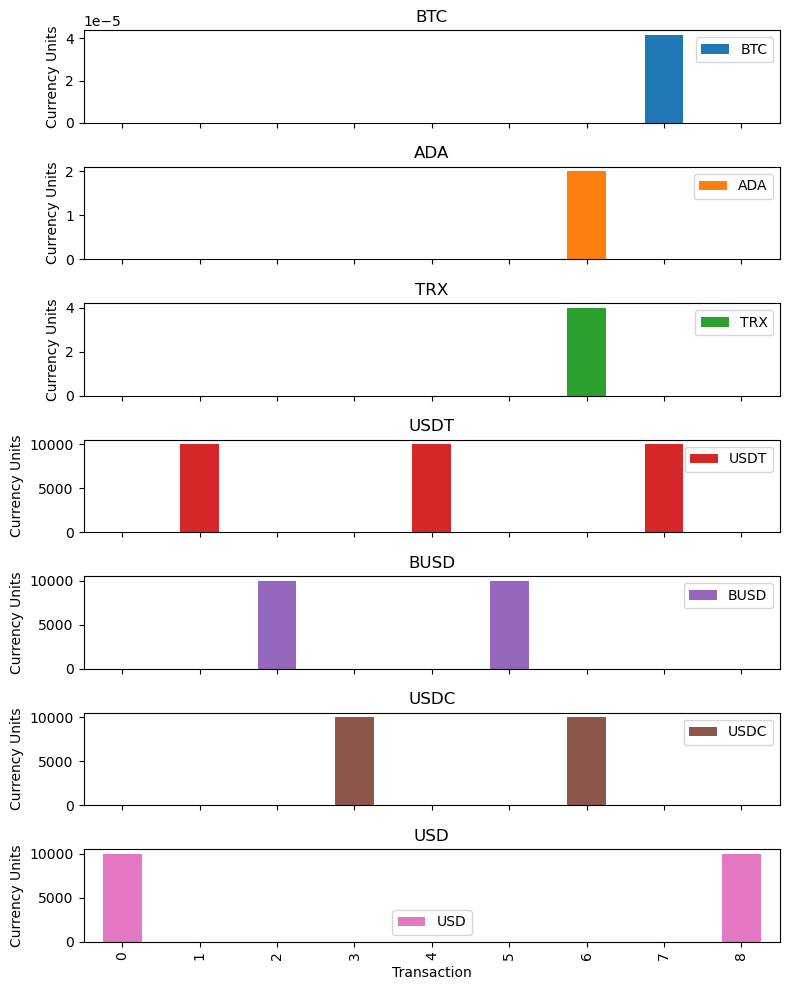

In [21]:
# display currency balances
balances = pd.DataFrame()
for node in dg_order_book.nodes:
    if sum(m.v[node, t]() for t in m.T0) > 0.0000002:
        for t in m.T0:
            balances.loc[t, node] = m.v[node, t]()

balances.plot(kind="bar", subplots=True, figsize=(8, 10), xlabel="Transaction", ylabel="Currency Units")
plt.gcf().tight_layout()
plt.show()

## Questions to the user

In the preceding notebook cells, we have relied silently on some assumptions. The first one was that between each pair of currencies in an exchange, we have at most one bid and at most one ask order. It corresponded simply to the number of orders per each pair that we downloaded from the online database, but in real life, there might be more orders. How would the presence of more such orders per pair would impact the way our graph formulation looks like? How would you modify the MILP formulation of our problem to take that into account?

Another aspect was that we only considered trading currencies within one exchange. In real life, however, nothing prohibits us from trading across multiple exchanges. How would you modify the graph-based problem formulation to fit this situation?

## Real Time Downloads of Order Books from an Exchange

The goal of this notebook was to show how network algorithms and optimization can be utilized to detect arbitrage opportunities within an order book that has been obtained from a cryptocurrency exchange.

The subsequent cell in the notebook utilizes `ccxt.exchange.fetch_order_book` to obtain the highest bid and lowest ask orders from an exchange for market symbols that meet the criteria of having a minimum in-degree for their base currencies.

In [22]:
import pandas as pd

def get_order_book(exchange, dg):

    def get_orders(base, quote, limit=1):
        """
        Return order book data for a specified symbol.
        """
        result = exchange.fetch_order_book("/".join([base, quote]), limit)
        if not result["asks"] or not result["bids"]:
            result = None
        else:
            result["base"], result["quote"] = base, quote
            result["timestamp"] = exchange.milliseconds()
            result["bid_price"], result["bid_volume"] = result["bids"][0] 
            result["ask_price"], result["ask_volume"] = result["asks"][0]
        return result

    # fetch order book data and store in a dictionary
    order_book = filter(lambda r: r is not None, [get_orders(base, quote) for quote, base in dg.edges()])

    # convert to pandas dataframe
    order_book = pd.DataFrame(order_book)
    order_book["timestamp"] = pd.to_datetime(order_book["timestamp"], unit="ms")

    return order_book[['symbol', 'timestamp', 'base', 'quote', 'bid_price', 'bid_volume', 'ask_price', 'ask_volume']]


minimum_in_degree = 5

# graph of market symbols with mininum_in_degree for base currencies
dg = get_dg(exchange, minimum_in_degree)

# retrieve order book for all markets in the graph
order_book = get_order_book(exchange, dg)

# find trades
v0 = 10000.0
m = crypto_model(dg_order_book, T=12, v0=v0)
wT = m.wealth()

print(f"Potential Return = {10000*(vT - v0)/v0:0.3f} basis points")
display(order_book)

Potential Return = 9.007 basis points


,symbol,timestamp,base,quote,bid_price,bid_volume,ask_price,ask_volume
0,ETH/BTC,2023-03-09 04:21:54.764,ETH,BTC,0.070771,1.01850,0.070804,1.300000e+00
1,BNB/BTC,2023-03-09 04:21:54.833,BNB,BTC,0.013320,3.00000,0.013331,3.294000e+00
2,ADA/BTC,2023-03-09 04:21:54.903,ADA,BTC,0.000015,8.10000,0.000015,9.571000e+02
3,SOL/BTC,2023-03-09 04:21:54.968,SOL,BTC,0.000851,15.03000,0.000853,1.504000e+01
4,MATIC/BTC,2023-03-09 04:21:55.048,MATIC,BTC,0.000049,5.70000,0.000049,6.458000e+02
5,MANA/BTC,2023-03-09 04:21:55.126,MANA,BTC,0.000025,1.00000,0.000025,1.029000e+03
6,TRX/BTC,2023-03-09 04:21:55.194,TRX,BTC,0.000003,4723.00000,0.000003,1.472500e+04
7,ADA/ETH,2023-03-09 04:21:55.275,ADA,ETH,0.000206,998.70000,0.000207,4.000000e-01
8,BTC/USDT,2023-03-09 04:21:55.340,BTC,USDT,21740.300000,0.02866,21742.490000,1.508000e-02
9,ETH/USDT,2023-03-09 04:21:55.404,ETH,USDT,1538.830000,2.40000,1539.360000,5.000000e-01


The following cell can be used to download additional order book data sets for testing.

In [23]:
from datetime import datetime
import time
import glob

search_time = 20
timeout = time.time() + search_time

# wait for arbitrage opportunity
while time.time() <= timeout:
    print(".", end="")
    order_book = get_order_book(exchange, dg)
    dg_order_book = order_book_to_dg(order_book)
    if nx.negative_edge_cycle(dg_order_book, weight="weight", heuristic=True):
        print("arbitrage found!")
        fname = f"{exchange} orderbook {datetime.utcnow().strftime('%Y%m%d_%H_%M_%S')}.csv".replace(" ", "_")
        order_book.to_csv(fname)
        print(f"order book saved to: {fname}")
        break
else:
    print("no arbitrage found in {search_time} seconds")
    

.arbitrage found!
order book saved to: Binance_US_orderbook_20230309_04_22_02.csv


How would the reader extend the current model to having more than one trade (i, j)?

How to combine multiple exchanges?

<!---

## Bibliographic Notes

Crytocurrency markets are relatively new compared to other markets, and relatively few academic papers are available that specifically address arbitrage on those markets. Early studies, such as the following, reported periods of large, recurrent arbitrage opportunities that exist across exchanges, and that can persist for several days or weeks.

> Makarov, I., & Schoar, A. (2020). Trading and arbitrage in cryptocurrency markets. Journal of Financial Economics, 135(2), 293-319.

Subsequent work reports these prices differentials do exist, but only at a fraction of the values previously reported, and only for fleeting periods of time. 

> Crépellière, T., & Zeisberger, S. (2020). Arbitrage in the Market for Cryptocurrencies. Available at SSRN 3606053.  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3606053

The use of network algorithms to identify cross-exchange arbitrage has appeared in the academic literature, and in numerous web sites demonstrating optimization and network applications. Representative examples are cited below.

> Peduzzi, G., James, J., & Xu, J. (2021, September). JACK THE RIPPLER: Arbitrage on the Decentralized Exchange of the XRP Ledger. In 2021 3rd Conference on Blockchain Research & Applications for Innovative Networks and Services (BRAINS) (pp. 1-2). IEEE. https://arxiv.org/pdf/2106.16158.pdf

> Bruzgė, R., & Šapkauskienė, A. (2022). Network analysis on Bitcoin arbitrage opportunities. The North American Journal of Economics and Finance, 59, 101562. https://doi.org/10.1016/j.najef.2021.101562

> Bruzgė, R., & Šapkauskienė, A. (2022). Dataset for Bitcoin arbitrage in different cryptocurrency exchanges. Data in Brief, 40, 107731. 

The work in this notebook is related to materials found in the following web resources.

> https://anilpai.medium.com/currency-arbitrage-using-bellman-ford-algorithm-8938dcea56ea

> [Crypto Trading and Arbitrage Identification Strategies](https://nbviewer.org/github/rcroessmann/sharing_public/blob/master/arbitrage_identification.ipynb)

A more complete analysis of trading and exploiting arbitrage opportunities in decentralized finance markets is available in the following paper and thesis.

> Byrne, S. An Exploration of Novel Trading and Arbitrage Methods within Decentralised Finance. https://www.scss.tcd.ie/Donal.OMahony/bfg/202021/StephenByrneDissertation.pdf

> Levus, R., Berko, A., Chyrun, L., Panasyuk, V., & Hrubel, M. (2021). Intelligent System for Arbitrage Situations Searching in the Cryptocurrency Market. In CEUR Workshop Proceedings (pp. 407-440). http://ceur-ws.org/Vol-2917/paper32.pdf

In addition to the analysis of arbitrage opportunities, convex optimization may also have an important role in the developing of trading algorithms for crypocurrency exchanges.

> Angeris, G., Agrawal, A., Evans, A., Chitra, T., & Boyd, S. (2021). Constant function market makers: Multi-asset trades via convex optimization. arXiv preprint arXiv:2107.12484. https://baincapitalcrypto.com/constant-function-market-makers-multi-asset-trades-via-convex-optimization/ and https://arxiv.org/pdf/2107.12484.pdf

--->